# Sector Ridge Signal IC Comparison

Compare the information coefficient (IC) of the Ridge-augmented signal vs the futures-only baseline signal
for predicting hedged ADR returns (long ADR, short market ETF) from various entry times to daily close (matching analyze_hedged_prediction.ipynb).

Signals clipped to [-0.01, 0.01].

**Only dates where the Ridge model was fit are included** — identified as dates where the Ridge signal
differs from the baseline signal. Only Ridge-eligible tickers are compared.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import spearmanr
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

DATA_DIR = Path('..') / 'data'
ENTRY_TIMES = ['13:00', '13:30', '14:00', '14:30', '15:00', '15:30']
ADR_CLOSE_FILE = DATA_DIR / 'raw' / 'adrs' / 'adr_PX_LAST_adjust_none.csv'
ETF_CLOSE_FILE = DATA_DIR / 'raw' / 'etfs' / 'market' / 'market_etf_PX_LAST_adjust_none.csv'


## Load metadata

In [2]:
# Load ADR info for ticker -> market ETF mapping
adr_info = pd.read_csv(DATA_DIR / 'raw' / 'adr_info.csv')
adr_info['ticker'] = adr_info['adr'].str.replace(' US Equity', '')
ticker_to_etf = dict(zip(adr_info['ticker'], adr_info['market_etf_hedge']))

# All tickers
all_tickers = sorted(adr_info['ticker'].tolist())
print(f'{len(all_tickers)} ADR tickers')
print(f'Market ETF mapping: {dict(pd.Series(ticker_to_etf).value_counts())}')

54 ADR tickers
Market ETF mapping: {'FEZ': 23, 'EWU': 22, 'EWJ': 7, 'EWA': 2}


In [3]:
# Load hedge ratios and daily close series used in analyze_hedged_prediction.ipynb
hedge_ratios = pd.read_csv(
    DATA_DIR / 'processed' / 'market_etf_hedge_ratios.csv',
    index_col=0, parse_dates=True
)
close_df = pd.read_csv(ADR_CLOSE_FILE, index_col=0, parse_dates=True)
etf_close_df = pd.read_csv(ETF_CLOSE_FILE, index_col=0, parse_dates=True)

print(f'Hedge ratios: {hedge_ratios.shape}')
print(f'ADR close: {close_df.shape}')
print(f'ETF close: {etf_close_df.shape}')


Hedge ratios: (1872, 54)
ADR close: (1959, 54)
ETF close: (1959, 4)


## Load NBBO data and compute mid prices at entry/close times

In [4]:
def load_nbbo_mid(path, col_name):
    """Load NBBO parquet and return DataFrame with mid + normalized date."""
    df = pd.read_parquet(path, columns=['nbbo_bid', 'nbbo_ask'])
    out = pd.DataFrame(index=df.index)
    out[col_name] = (df['nbbo_bid'] + df['nbbo_ask']) / 2
    out['date'] = out.index.tz_localize(None).normalize()
    return out


def extract_prices_at_times(mid_df, times, value_col):
    """
    Extract exact minute prices for each date (matching analyze_hedged_prediction).
    Returns DataFrame indexed by date with one column per entry time.
    """
    all_dates = sorted(mid_df['date'].unique())
    res = pd.DataFrame(index=pd.DatetimeIndex(all_dates))

    for t in times:
        s = mid_df.between_time(t, t)[value_col]
        if len(s) == 0:
            res[t] = np.nan
            continue

        idx = s.index.tz_localize(None).normalize()
        ser = pd.Series(s.values, index=idx).groupby(level=0).first()
        res[t] = ser.reindex(res.index)

    return res


In [5]:
# Load ADR mid prices at entry times
adr_prices = {}  # ticker -> DataFrame(date x entry_times)
print('Loading ADR NBBO data...')
for ticker in tqdm(all_tickers):
    path = DATA_DIR / 'raw' / 'adrs' / 'bbo-1m' / 'nbbo' / f'ticker={ticker}' / 'data.parquet'
    if not path.exists():
        continue
    mid = load_nbbo_mid(path, 'mid')
    adr_prices[ticker] = extract_prices_at_times(mid, ENTRY_TIMES, 'mid')

print(f'Loaded ADR prices for {len(adr_prices)} tickers')


Loading ADR NBBO data...


  0%|          | 0/54 [00:00<?, ?it/s]

Loaded ADR prices for 54 tickers


In [6]:
# Load ETF mid prices at entry times
etf_prices = {}  # etf -> DataFrame(date x entry_times)
unique_etfs = set(ticker_to_etf.values())
print(f'Loading ETF NBBO data for: {unique_etfs}')
for etf in unique_etfs:
    path = DATA_DIR / 'raw' / 'etfs' / 'market' / 'bbo-1m' / 'nbbo' / f'ticker={etf}' / 'data.parquet'
    if not path.exists():
        print(f'  WARNING: {path} not found')
        continue
    mid = load_nbbo_mid(path, 'etf_mid')
    etf_prices[etf] = extract_prices_at_times(mid, ENTRY_TIMES, 'etf_mid')
    print(f'  {etf}: {etf_prices[etf].shape}')

print(f'Loaded ETF prices for {len(etf_prices)} ETFs')


Loading ETF NBBO data for: {'EWA', 'EWJ', 'FEZ', 'EWU'}
  EWA: (1959, 6)


  EWJ: (1959, 6)
  FEZ: (1959, 6)


  EWU: (1959, 6)
Loaded ETF prices for 4 ETFs


## Compute actual hedged returns from entry to daily close

In [7]:
# For each ticker and entry time, compute:
#   hedged_return = adr_return(entry->daily_close) - hedge_ratio * etf_return(entry->daily_close)
# where entry uses NBBO mid at each ENTRY_TIME and close uses daily close files

hedged_returns = {}  # (ticker, entry_time) -> Series indexed by date

for ticker in all_tickers:
    if ticker not in adr_prices:
        continue
    etf = ticker_to_etf.get(ticker)
    if etf not in etf_prices:
        continue
    if ticker not in hedge_ratios.columns:
        continue
    if ticker not in close_df.columns:
        continue
    if etf not in etf_close_df.columns:
        continue

    adr_px = adr_prices[ticker]
    etf_px = etf_prices[etf]

    adr_close = close_df[ticker].dropna()
    etf_close = etf_close_df[etf].dropna()
    hr = hedge_ratios[ticker].dropna()

    common_dates = (
        adr_px.index
        .intersection(etf_px.index)
        .intersection(adr_close.index)
        .intersection(etf_close.index)
    )

    if len(common_dates) == 0:
        continue

    for entry_time in ENTRY_TIMES:
        adr_entry = adr_px.loc[common_dates, entry_time]
        etf_entry = etf_px.loc[common_dates, entry_time]

        valid = adr_entry.notna() & etf_entry.notna()
        d = common_dates[valid.values]
        if len(d) == 0:
            continue

        ae = adr_entry.loc[d].astype(float)
        ee = etf_entry.loc[d].astype(float)
        ac = adr_close.reindex(d).astype(float)
        ec = etf_close.reindex(d).astype(float)
        hr_aligned = hr.reindex(d).astype(float)

        adr_ret = (ac - ae) / ae
        etf_ret = (ec - ee) / ee
        hedged = adr_ret - hr_aligned * etf_ret

        hedged = hedged.replace([np.inf, -np.inf], np.nan).dropna()
        if len(hedged) == 0:
            continue

        hedged_returns[(ticker, entry_time)] = pd.Series(
            hedged.values, index=hedged.index, name=ticker
        )

print(f'Computed hedged returns for {len(hedged_returns)} (ticker, time) pairs')


Computed hedged returns for 324 (ticker, time) pairs


## Load signals at entry times

In [8]:
def load_signal_at_times(signal_dir, tickers, entry_times):
    """
    Load signal values at each entry time for each ticker.
        Returns dict: (ticker, entry_time) -> Series indexed by normalized Timestamp date.
    """
    signals = {}
    for ticker in tqdm(tickers):
        path = signal_dir / f'ticker={ticker}' / 'data.parquet'
        if not path.exists():
            continue
        df = pd.read_parquet(path)

        for entry_time in entry_times:
            h, m = map(int, entry_time.split(':'))
            mask = (df.index.hour == h) & (df.index.minute == m)
            sig_at_time = df.loc[mask, 'signal']
            if len(sig_at_time) == 0:
                continue

            idx = sig_at_time.index.tz_localize(None).normalize()
            ser = pd.Series(sig_at_time.values, index=idx).groupby(level=0).first()
            signals[(ticker, entry_time)] = ser

    return signals


print('Loading Ridge signals...')
ridge_signals = load_signal_at_times(
    DATA_DIR / 'processed' / 'index_sector_etf_ridge_signal',
    all_tickers, ENTRY_TIMES
)
print(f'  {len(ridge_signals)} (ticker, time) pairs')

print('Loading baseline signals...')
baseline_signals = load_signal_at_times(
    DATA_DIR / 'processed' / 'futures_only_signal',
    all_tickers, ENTRY_TIMES
)
print(f'  {len(baseline_signals)} (ticker, time) pairs')


Loading Ridge signals...


  0%|          | 0/54 [00:00<?, ?it/s]

  324 (ticker, time) pairs
Loading baseline signals...


  0%|          | 0/54 [00:00<?, ?it/s]

  324 (ticker, time) pairs


## Identify Ridge-active dates and filter

For each Ridge-eligible ticker and entry time, find dates where the Ridge signal differs
from the baseline (i.e., where the Ridge model was actually applied, not falling back to baseline).

In [9]:

# Sector-eligible ADRs (from data/raw/sector_etfs.csv)
sector_map = pd.read_csv(DATA_DIR / 'raw' / 'sector_etfs.csv')
sector_map['adr'] = sector_map['adr'].astype(str).str.strip()
sector_map['hedge'] = sector_map['hedge'].astype(str).str.strip()
sector_map = sector_map.replace({'hedge': {'': pd.NA, 'nan': pd.NA}}).dropna(subset=['hedge'])
RIDGE_ELIGIBLE = sorted(set(sector_map['adr']).intersection(set(all_tickers)))
print(f'Sector-eligible tickers: {len(RIDGE_ELIGIBLE)}')
print(RIDGE_ELIGIBLE)


Sector-eligible tickers: 18
['AZN', 'BCS', 'BP', 'BTI', 'DEO', 'GSK', 'HLN', 'HSBC', 'IHG', 'LYG', 'NGG', 'NWG', 'RELX', 'RIO', 'SHEL', 'SNN', 'UL', 'WPP']


In [10]:

# Sector-eligible ADRs (from data/raw/sector_etfs.csv)
sector_map = pd.read_csv(DATA_DIR / 'raw' / 'sector_etfs.csv')
sector_map['adr'] = sector_map['adr'].astype(str).str.strip()
sector_map['hedge'] = sector_map['hedge'].astype(str).str.strip()
sector_map = sector_map.replace({'hedge': {'': pd.NA, 'nan': pd.NA}}).dropna(subset=['hedge'])
RIDGE_ELIGIBLE = sorted(set(sector_map['adr']).intersection(set(all_tickers)))
print(f'Sector-eligible tickers: {len(RIDGE_ELIGIBLE)}')

# For each (ticker, entry_time), find dates where the Ridge model was fit
# (i.e., where ridge signal != baseline signal)
ridge_active_dates = {}  # (ticker, entry_time) -> set of dates

for ticker in RIDGE_ELIGIBLE:
    for entry_time in ENTRY_TIMES:
        key = (ticker, entry_time)
        if key not in ridge_signals or key not in baseline_signals:
            continue
        ridge_sig = ridge_signals[key]
        base_sig = baseline_signals[key]
        common = ridge_sig.index.intersection(base_sig.index)
        l = ridge_sig.loc[common]
        b = base_sig.loc[common]
        # Dates where signals differ (Ridge model was applied)
        differs = l.values != b.values
        active_dates = set(common[differs])
        ridge_active_dates[key] = active_dates

# Summary
total_pairs = 0
total_active = 0
for key, dates in ridge_active_dates.items():
    total_pairs += 1
    total_active += len(dates)
print(f'{total_pairs} (ticker, time) pairs with Ridge-active dates')
print(f'{total_active} total Ridge-active (ticker, time, date) observations')
if total_pairs > 0:
    print(f'Mean {total_active / total_pairs:.0f} active dates per (ticker, time) pair')

# Show per-ticker active date counts at 14:30
print(f'\nRidge-active dates per ticker at 14:30:')
for ticker in RIDGE_ELIGIBLE:
    key = (ticker, '14:30')
    n = len(ridge_active_dates.get(key, set()))
    print(f'  {ticker}: {n}')


Sector-eligible tickers: 18


108 (ticker, time) pairs with Ridge-active dates


124935 total Ridge-active (ticker, time, date) observations
Mean 1157 active dates per (ticker, time) pair

Ridge-active dates per ticker at 14:30:
  AZN: 1597
  BCS: 0
  BP: 1597
  BTI: 1597
  DEO: 1597
  GSK: 1594
  HLN: 789
  HSBC: 0
  IHG: 1597
  LYG: 0
  NGG: 1557
  NWG: 0
  RELX: 1576
  RIO: 1597
  SHEL: 942
  SNN: 1597
  UL: 1597
  WPP: 1576


In [11]:
def compute_ic_filtered(signals, hedged_returns, entry_times, tickers,
                        date_filter=None, min_obs=30):
    """
    Compute IC (Pearson correlation) between signal and hedged return.
    
    Args:
        date_filter: dict of (ticker, entry_time) -> set of dates to include.
                     If None, use all dates.
    
    Returns:
        per_ticker_ic: DataFrame (tickers x entry_times) of per-ticker ICs
        per_ticker_n: DataFrame (tickers x entry_times) of observation counts
        pooled_ic: Series indexed by entry_time of pooled ICs
        cross_sectional_ic: Series indexed by entry_time of mean cross-sectional ICs
    """
    per_ticker_ic = pd.DataFrame(index=tickers, columns=entry_times, dtype=float)
    per_ticker_n = pd.DataFrame(index=tickers, columns=entry_times, dtype=float)
    pooled_data = {t: {'signal': [], 'actual': []} for t in entry_times}
    cs_ic_by_date = {t: {} for t in entry_times}
    
    for ticker in tickers:
        for entry_time in entry_times:
            key = (ticker, entry_time)
            if key not in signals or key not in hedged_returns:
                continue
            
            sig = signals[key]
            ret = hedged_returns[key]
            
            # Align
            common = sig.index.intersection(ret.index)
            
            # Apply date filter
            if date_filter is not None and key in date_filter:
                common = common.intersection(pd.Index(list(date_filter[key])))
            
            if len(common) < min_obs:
                continue
            
            s = sig.loc[common].values
            r = ret.loc[common].values
            
            # Drop NaN/inf pairs
            valid = ~(np.isnan(s) | np.isnan(r) | np.isinf(s) | np.isinf(r))
            s, r = s[valid], r[valid]
            common_valid = np.array(common)[valid]
            
            if len(s) < min_obs:
                continue
            
            # Per-ticker IC (Pearson)
            corr = np.corrcoef(s, r)[0, 1]
            per_ticker_ic.loc[ticker, entry_time] = corr
            per_ticker_n.loc[ticker, entry_time] = len(s)
            
            # Collect for pooled
            pooled_data[entry_time]['signal'].extend(s.tolist())
            pooled_data[entry_time]['actual'].extend(r.tolist())
            
            # Collect for cross-sectional
            for date, sv, rv in zip(common_valid, s, r):
                if date not in cs_ic_by_date[entry_time]:
                    cs_ic_by_date[entry_time][date] = []
                cs_ic_by_date[entry_time][date].append((sv, rv))
    
    # Pooled IC
    pooled_ic = pd.Series(index=entry_times, dtype=float, name='pooled_ic')
    pooled_n = pd.Series(index=entry_times, dtype=int, name='pooled_n')
    for t in entry_times:
        s = np.array(pooled_data[t]['signal'])
        r = np.array(pooled_data[t]['actual'])
        pooled_n[t] = len(s)
        if len(s) > min_obs:
            pooled_ic[t] = np.corrcoef(s, r)[0, 1]
    
    # Cross-sectional IC (mean daily IC)
    cs_ic = pd.Series(index=entry_times, dtype=float, name='cross_sectional_ic')
    cs_ic_std = pd.Series(index=entry_times, dtype=float, name='cs_ic_std')
    cs_n_days = pd.Series(index=entry_times, dtype=int, name='n_days')
    min_tickers_per_date = 5
    for t in entry_times:
        daily_ics = []
        for date, pairs in cs_ic_by_date[t].items():
            if len(pairs) < min_tickers_per_date:
                continue
            sigs, rets = zip(*pairs)
            corr = np.corrcoef(sigs, rets)[0, 1]
            if not np.isnan(corr):
                daily_ics.append(corr)
        if daily_ics:
            cs_ic[t] = np.mean(daily_ics)
            cs_ic_std[t] = np.std(daily_ics) / np.sqrt(len(daily_ics))
            cs_n_days[t] = len(daily_ics)
    
    return per_ticker_ic, per_ticker_n, pooled_ic, pooled_n, cs_ic, cs_ic_std, cs_n_days

## Compute IC on Ridge-active dates only

Both signals are evaluated on the **same dates** — only those where the Ridge model was fit.
This gives a fair apples-to-apples comparison.

In [12]:
print('Computing ICs for Ridge signal (Ridge-active dates only)...')
ridge_per_ticker, ridge_per_n, ridge_pooled, ridge_pooled_n, ridge_cs, ridge_cs_std, ridge_cs_ndays = \
    compute_ic_filtered(ridge_signals, hedged_returns, ENTRY_TIMES, RIDGE_ELIGIBLE,
                        date_filter=ridge_active_dates)

print('Computing ICs for baseline signal (same Ridge-active dates)...')
base_per_ticker, base_per_n, base_pooled, base_pooled_n, base_cs, base_cs_std, base_cs_ndays = \
    compute_ic_filtered(baseline_signals, hedged_returns, ENTRY_TIMES, RIDGE_ELIGIBLE,
                        date_filter=ridge_active_dates)

print(f'\nPooled obs per entry time: {dict(ridge_pooled_n)}')

Computing ICs for Ridge signal (Ridge-active dates only)...


Computing ICs for baseline signal (same Ridge-active dates)...



Pooled obs per entry time: {'13:00': 20509.0, '13:30': 20422.0, '14:00': 20411.0, '14:30': 20411.0, '15:00': 20411.0, '15:30': 20373.0}


## Results: Pooled IC comparison (Ridge-active dates only)

In [13]:
ic_comparison = pd.DataFrame({
    'Ridge': ridge_pooled,
    'Baseline': base_pooled,
    'Improvement': ridge_pooled - base_pooled,
    'N obs': ridge_pooled_n
})
ic_comparison.index.name = 'Entry Time'
print('Pooled IC (Pearson corr, signal vs hedged return to daily close)')
print('Ridge-active dates only, Ridge-eligible tickers only')
print('=' * 65)
display(ic_comparison.round(4))

Pooled IC (Pearson corr, signal vs hedged return to daily close)
Ridge-active dates only, Ridge-eligible tickers only


,Ridge,Baseline,Improvement,N obs
Entry Time,,,,
13:00,0.0276,0.0257,0.0019,20509.0
13:30,0.0264,0.0240,0.0024,20422.0
14:00,0.0290,0.0292,-0.0002,20411.0
14:30,0.0238,0.0249,-0.0011,20411.0
15:00,0.0218,0.0221,-0.0003,20411.0
15:30,0.0204,0.0203,0.0002,20373.0


## Results: Cross-sectional IC comparison (Ridge-active dates only)

In [14]:
cs_comparison = pd.DataFrame({
    'Ridge IC': ridge_cs,
    'Ridge SE': ridge_cs_std,
    'Baseline IC': base_cs,
    'Baseline SE': base_cs_std,
    'Improvement': ridge_cs - base_cs,
    'N days': ridge_cs_ndays
})
cs_comparison.index.name = 'Entry Time'
print('Cross-sectional IC (mean daily Pearson corr across tickers)')
print('Ridge-active dates only, Ridge-eligible tickers only')
print('=' * 65)
display(cs_comparison.round(4))

Cross-sectional IC (mean daily Pearson corr across tickers)
Ridge-active dates only, Ridge-eligible tickers only


,Ridge IC,Ridge SE,Baseline IC,Baseline SE,Improvement,N days
Entry Time,,,,,,
13:00,0.0403,0.0082,0.0393,0.0081,0.0010,1605.0
13:30,0.0405,0.0082,0.0359,0.0081,0.0046,1598.0
14:00,0.0437,0.0082,0.0418,0.0081,0.0019,1597.0
14:30,0.0392,0.0082,0.0417,0.0081,-0.0025,1597.0
15:00,0.0354,0.0082,0.0339,0.0081,0.0015,1597.0
15:30,0.0347,0.0083,0.0315,0.0082,0.0032,1594.0


In [15]:
## Results: Per-ticker IC comparison (Ridge-active dates only)

In [16]:
# Per-ticker IC at 14:30 (the main entry time)
main_time = '14:30'
per_ticker_comparison = pd.DataFrame({
    'Ridge IC': ridge_per_ticker[main_time],
    'Baseline IC': base_per_ticker[main_time],
    'Improvement': ridge_per_ticker[main_time].astype(float) - base_per_ticker[main_time].astype(float),
    'N obs': ridge_per_n[main_time]
}).dropna().sort_values('Improvement', ascending=False)

print(f'Per-ticker IC at {main_time} entry (Ridge-active dates only)')
print('=' * 65)
display(per_ticker_comparison.round(4))

Per-ticker IC at 14:30 entry (Ridge-active dates only)


,Ridge IC,Baseline IC,Improvement,N obs
AZN,0.0294,0.0049,0.0244,1420.0
IHG,0.1342,0.1124,0.0218,1597.0
SNN,0.1292,0.1099,0.0193,1597.0
RELX,0.1228,0.1151,0.0078,1576.0
BTI,0.0740,0.0672,0.0068,1597.0
HLN,0.2047,0.1992,0.0054,567.0
GSK,0.0756,0.0742,0.0015,1594.0
WPP,0.1887,0.1873,0.0014,1576.0
SHEL,0.0464,0.0490,-0.0026,942.0
DEO,0.1025,0.1064,-0.0040,1597.0


In [17]:
# Mean per-ticker IC across all entry times
ridge_mean_ic = ridge_per_ticker.astype(float).mean()
base_mean_ic = base_per_ticker.astype(float).mean()

mean_comparison = pd.DataFrame({
    'Ridge': ridge_mean_ic,
    'Baseline': base_mean_ic,
    'Improvement': ridge_mean_ic - base_mean_ic
})
mean_comparison.index.name = 'Entry Time'
print('Mean per-ticker IC (across Ridge-eligible tickers, Ridge-active dates only)')
print('=' * 65)
display(mean_comparison.round(4))

Mean per-ticker IC (across Ridge-eligible tickers, Ridge-active dates only)


,Ridge,Baseline,Improvement
Entry Time,,,
13:00,0.1861,0.1853,0.0008
13:30,0.1015,0.0967,0.0048
14:00,0.0989,0.0961,0.0028
14:30,0.1126,0.1124,0.0002
15:00,0.1049,0.0979,0.0070
15:30,0.0743,0.0757,-0.0014


## Visualization

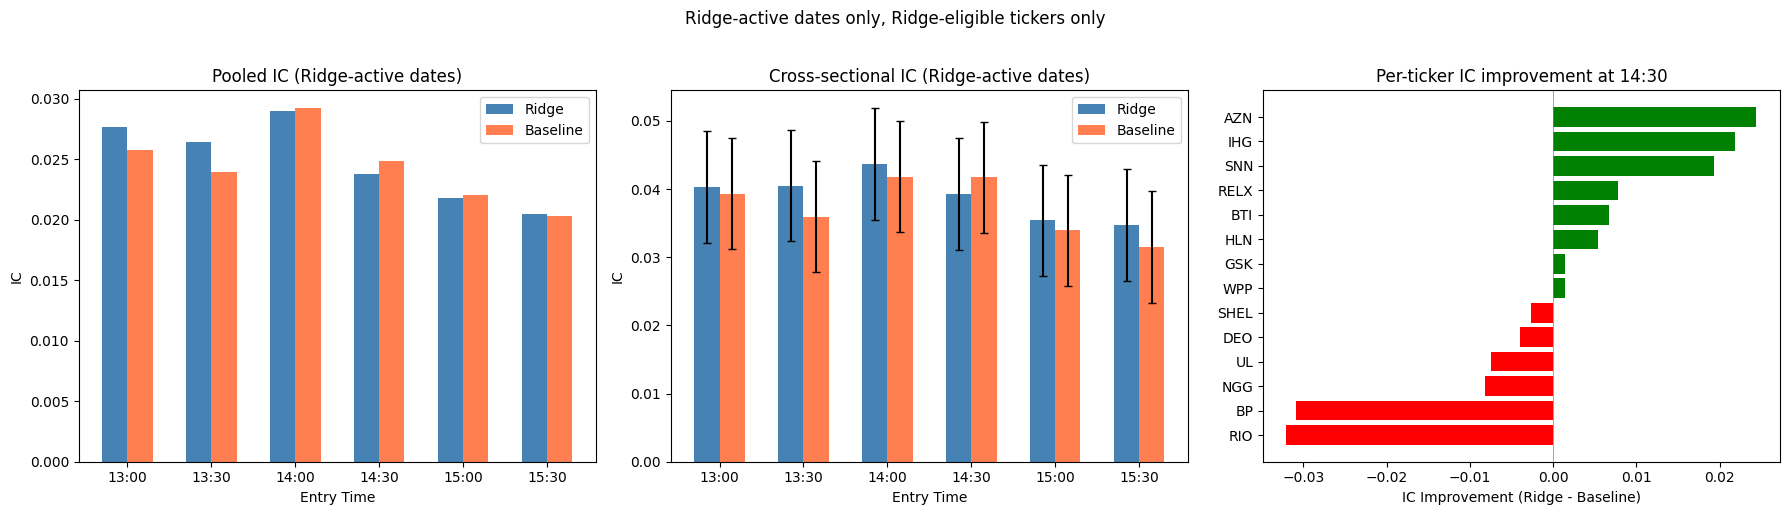

In [18]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Pooled IC
ax = axes[0]
x = range(len(ENTRY_TIMES))
ax.bar([i - 0.15 for i in x], ridge_pooled.values, 0.3, label='Ridge', color='steelblue')
ax.bar([i + 0.15 for i in x], base_pooled.values, 0.3, label='Baseline', color='coral')
ax.set_xticks(x)
ax.set_xticklabels(ENTRY_TIMES)
ax.set_xlabel('Entry Time')
ax.set_ylabel('IC')
ax.set_title('Pooled IC (Ridge-active dates)')
ax.legend()
ax.axhline(0, color='gray', linewidth=0.5)

# Plot 2: Cross-sectional IC
ax = axes[1]
ax.bar([i - 0.15 for i in x], ridge_cs.values, 0.3, label='Ridge', color='steelblue',
       yerr=ridge_cs_std.values, capsize=3)
ax.bar([i + 0.15 for i in x], base_cs.values, 0.3, label='Baseline', color='coral',
       yerr=base_cs_std.values, capsize=3)
ax.set_xticks(x)
ax.set_xticklabels(ENTRY_TIMES)
ax.set_xlabel('Entry Time')
ax.set_ylabel('IC')
ax.set_title('Cross-sectional IC (Ridge-active dates)')
ax.legend()
ax.axhline(0, color='gray', linewidth=0.5)

# Plot 3: Per-ticker IC improvement at 14:30
ax = axes[2]
eligible_improvement = per_ticker_comparison['Improvement'].sort_values()
colors = ['green' if v > 0 else 'red' for v in eligible_improvement.values]
ax.barh(range(len(eligible_improvement)), eligible_improvement.values, color=colors)
ax.set_yticks(range(len(eligible_improvement)))
ax.set_yticklabels(eligible_improvement.index)
ax.set_xlabel('IC Improvement (Ridge - Baseline)')
ax.set_title(f'Per-ticker IC improvement at {main_time}')
ax.axvline(0, color='gray', linewidth=0.5)

plt.suptitle('Ridge-active dates only, Ridge-eligible tickers only', y=1.02)
plt.tight_layout()
plt.show()

In [19]:

# Save parity outputs for one-to-one comparison with pipeline script
from pathlib import Path
OUT_DIR = Path('..') / 'data' / 'processed' / 'models' / 'with_us_stocks' / 'ridge_sector_etf_parity_notebook'
OUT_DIR.mkdir(parents=True, exist_ok=True)

ic_comparison.to_csv(OUT_DIR / 'pooled_ic.csv')
cs_comparison.to_csv(OUT_DIR / 'cross_sectional_ic.csv')
per_ticker_comparison.to_csv(OUT_DIR / 'per_ticker_1430_ic.csv')
mean_comparison.to_csv(OUT_DIR / 'mean_per_ticker_ic.csv')
print(f"Saved notebook parity outputs to {OUT_DIR}")


Saved notebook parity outputs to ../data/processed/models/with_us_stocks/ridge_sector_etf_parity_notebook
